# Stock Price Prediction with Milvus

Attempting to predict stock market prices is a common goal of machine learning models. In this notebook, we will examine several methods of predicting stock prices, and how we can make use of [Milvus](https://milvus.io) as part of our models. 

## Summary
We test three different methods of stock price prediction: A LSTM model, a Milvus search average, and a LSTM ensemble from a Milvus search.

[Long-Short Term Models (LSTM)](https://en.wikipedia.org/wiki/Long_short-term_memory) are a type of recurrent neural network which excels as processing time-series data. Due to this, it is a commonly chosen model for stock market analysis, as stock market trends are a form of time-series data. LSTMs are often trained on a singular time-series set. We train a LSTM model on a target stock, and then generate price predictions from the model.

The second method is a raw form of prediction made using [Milvus](https://milvus.io). In this method, we search historical stock data across all stocks in the dataset to find periods of similar price history to the target stock. We then take a weighted average of these known stock prices to generate a prediction for our target stock.

In the third method, we combine LSTM models and Milvus as a form of [Ensemble Learning](https://en.wikipedia.org/wiki/Ensemble_learning). After selecting a target stock and time period, we leverage Milvus to find similar stock time periods from our historical data. We then use classifiers trained on each stock to create predictions for our target stock, combined using a weighted average into a single prediction. 

### Requirements
To run this project, you'll need a Milvus 1.1.0 server and a MySQL server. We use Milvus to store and search vector embeddings of stocks; we use MySQL to store file path and timeframe data for each entry in Milvus.

Setup the Milvus and MySQL servers seperately, or run the two cells below to set up fresh servers with Docker.

In [2]:
! docker run --name milvus_cpu_1.1.0 -d \
-p 19530:19530 \
-p 19121:19121 \
milvusdb/milvus:1.1.0-cpu-d050721-5e559c

docker: Error response from daemon: Conflict. The container name "/milvus_cpu_1.1.0" is already in use by container "565a57fc80a3467f9be76d93b8ec494121726221c5318fb1fd473d13926390b0". You have to remove (or rename) that container to be able to reuse that name.
See 'docker run --help'.


In [4]:
! docker run -p 3306:3306 -e MYSQL_ROOT_PASSWORD=123456 -d mysql:5.7

13b9d7253119c1462c37626ee47a81d6b1fb9ca6adce2f9b63249c30578deb88
docker: Error response from daemon: driver failed programming external connectivity on endpoint xenodochial_blackwell (e088cc8db9348fe1c0551d4d3e72ff69804f09927e49697ddc67cc76886a425f): Bind for 0.0.0.0:3306 failed: port is already allocated.


### Dataset
This project makes use of the [Huge Stock Market Dataset (HSMC)](https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs), which contains historical daily data from U.S. based stocks traded on NYSE and  NASDAQ. Download and extract the dataset to the same directory as this notebook.

### Python Imports
We make use of pandas, numpy, and sklearn to process our data. We use Keras to build our models.

In [ ]:
%pip install -r requirements.txt

In [157]:
import os
import pandas as pd
import numpy as np
import pymysql
from milvus import Milvus, MetricType
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
from datetime import date
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, LSTM
from keras import initializers

### Configuration

Configuration variables for our project.

In [72]:
#config settings
STOCK_METRIC = 'Close'
STOCK_WIDTH = 20
STOCK_TIME_STEP = 5
LSTM_INPUT_WIDTH = 60
PREDICTION_SIZE = 15

DATASET_PATH = "data/archive/Stocks"
MILVUS_HOST = '127.0.0.1'
MILVUS_PORT = 19530
MILVUS_COLLECTION_NAME = 'stock_historical'
INDEX_FILE_SIZE = 1024
METRIC_TYPE = MetricType.IP

MYSQL_HOST = '127.0.0.1'
MYSQL_PORT = 3306
MYSQL_USER = 'root'
MYSQL_PWD = '123456'
MYSQL_DB = 'mysql'
MYSQL_TABLE = 'milvus_stock_search'

Variables specifying which stock we're going to be testing our system on.

In [215]:
stock_filepath = 'data/archive/Stocks/agu.us.txt'
start_date = date(2017,9,8)
end_date = date(2017,10,6)

Basic data operation functions

In [3]:
def read_from_file(path):
    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
    df['Date'] = df['Date'].apply(lambda x: x.date())
    df.index = df['Date']
    df = df[[STOCK_METRIC]]
    return df

In [5]:
def partition_data(df, duration, time_step):
    stock_sets, date_starts, date_ends = [], [], []
    for i in range(0,len(df) - duration,time_step):
        stock_set = df.iloc[i:i + duration]
        scaler = StandardScaler()
        scaled_stock_set = scaler.fit_transform(stock_set)
        stock_sets.append(np.stack(scaled_stock_set, axis=1).tolist()[0])
        date_starts.append(df.index[i])
        date_ends.append(df.index[i + duration])
    return stock_sets, date_starts, date_ends

In [7]:
def training_validation_split(df, split_size):
    return df.iloc[:-split_size], df.iloc[-split_size:]

### Database Management

Before we start predicting, we set up our databases for use later in the project. We create new tables and collections in our databases to hold our data.

In [80]:
def load_data_to_mysql(data):
    sql = "insert into " + MYSQL_TABLE + " (milvus_id,file_path,start_date,end_date) values (%s,%s,%s,%s);"
    cursor.executemany(sql, data)
    conn.commit()

In [81]:
client = Milvus(host=MILVUS_HOST, port=MILVUS_PORT)
try:
    if not client.has_collection(MILVUS_COLLECTION_NAME)[1]:
        collection_param = {
            'collection_name': MILVUS_COLLECTION_NAME,
            'dimension': STOCK_WIDTH,
            'index_file_size': INDEX_FILE_SIZE,
            'metric_type': METRIC_TYPE
        }
        status = client.create_collection(collection_param)
        if status.code != 0:
            raise Exception(status.message)
except Exception as e:
    print("Failed to load data to Milvus: {}".format(e))

In [82]:
conn = pymysql.connect(host=MYSQL_HOST, user=MYSQL_USER, port=MYSQL_PORT, 
                       password=MYSQL_PWD, database=MYSQL_DB, local_infile=True)
cursor = conn.cursor()
sql = "create table if not exists " + MYSQL_TABLE + "(milvus_id BIGINT NOT NULL PRIMARY KEY, file_path TEXT, start_date DATE, end_date DATE);"
try:
    cursor.execute(sql)
except Exception as e:
    print("MYSQL ERROR: {} with sql: {}".format(e, sql))

If you need to reset the databases, uncomment the cell below. Please use caution to avoid deleting important data. 

In [26]:
##Uncomment the code in this cell to delete Milvus collections and MySQL tables.
##WARNING: Use this with caution

#cursor.execute("DROP table milvus_stock_search;")
#client.drop_collection(collection_name=MILVUS_COLLECTION_NAME)  


### Data Retrieval

Helper functions to retrieve and clean data

In [188]:
def fetch_period(path, start=date(1900,1,1), end=date(2017,10,6), additional=0, starti = 0, scaler=None, fit_scaler=False):
    df = read_from_file(path)
    if start != date(1900,1,1) and starti == 0:
        starti = df.index.get_loc(start)
        
    endi = df.index.get_loc(end)
    df = df.iloc[starti:endi + additional]
    if scaler==None:
        scaler = StandardScaler()
        if additional > 0:
            scaler.fit(df.iloc[:-additional])
        else:
            scaler.fit(df)
    if fit_scaler:
        if additional > 0:
            scaler.fit(df.iloc[:-additional])
        else:
            scaler.fit(df)

    
    df[df.columns] = scaler.transform(df[df.columns])
    return df

In [189]:
def fetch_from_mysql(ids):
    data = []
    for milvus_id in ids:
        sql = "SELECT file_path, start_date, end_date FROM " + MYSQL_TABLE + " where milvus_id=" + str(milvus_id) + ";"
        cursor.execute(sql)
        data.append(cursor.fetchall()[0])
    return data

In [190]:
def clean_data(milvus_results, mysql_results, threshold):
    cleaned_milvus_results = []
    cleaned_mysql_results = []
    for milvus_row, mysql_row in zip(milvus_results[0], mysql_results):
        if read_from_file(mysql_row[0]).index.get_loc(mysql_row[1]) > threshold:
            cleaned_milvus_results.append(milvus_row)
            cleaned_mysql_results.append(mysql_row)
    return [cleaned_milvus_results], cleaned_mysql_results

### LSTMs

Now we'll try analysis using a basic LSTM. Our model consists of three layers; two LSTM layers with 50 units each, and a Dense layer that serves to output a single prediction. We use our model by feeding in the preceeding 60 data points from a stock as our X input, with the next data point being the Y output. We use a MSE loss function to train our model. 

In [195]:
def build_model(path, end, fit_scaler=False):
    scaler = StandardScaler()
    scaled_data = fetch_period(path, end=end, scaler=scaler, fit_scaler=fit_scaler)
    x_train, y_train = [], []
    for i in range(60,len(scaled_data.values)):
        x_train.append(scaled_data.values[i-60:i,0])
        y_train.append(scaled_data.values[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)

    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True))
    model.add(LSTM(units=50))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)
    return model, scaler

Let's take a look at a randomly selected stock, "AGU". The stock used can be adjusted by changing the "stock_filepath" variable in the configuration section at the beginning of this notebook. We'll use this stock and build a LSTM from it.

In [196]:
model, scalermain = build_model(stock_filepath, date(2017,10,6), fit_scaler=True)

3115/3115 - 41s - loss: 0.0117


Using the model we trained, we'll predict a set of 15 future values for our stock's closing price. We will use a [Mean Absolute Percentage Error(MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) as a validation metric for performance.

In [199]:
inputs = fetch_period(stock_filepath, starti = -86, end=date(2017,10,6), additional=PREDICTION_SIZE, scaler=scalermain).values
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
original_points_scaled = scalermain.inverse_transform(original_points)
closing_price_scaled = scalermain.inverse_transform(closing_price)

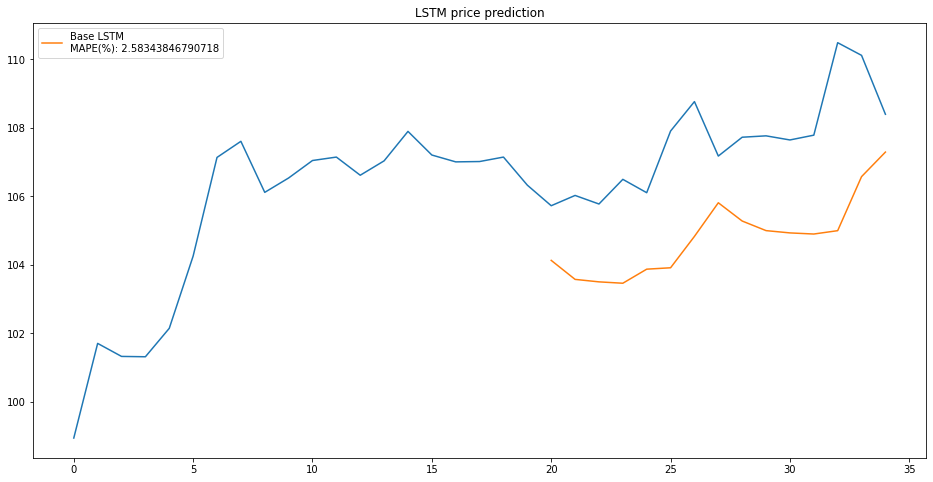

In [216]:
plt.figure(figsize=(16,8))
plt.title("LSTM price prediction")
original_points = inputs[-(STOCK_WIDTH + PREDICTION_SIZE):]
plt.plot(original_points_scaled)

lstm_mape = mean_absolute_percentage_error(original_points_scaled[-PREDICTION_SIZE:], closing_price_scaled)
plt.plot(range(STOCK_WIDTH, STOCK_WIDTH + PREDICTION_SIZE), closing_price_scaled, label = "Base LSTM\nMAPE(%): " + str(lstm_mape * 100))
plt.legend()

As we can see, a LSTM follows the general trends of the stock price, but with a MAPE of 2.5834%, there is room for improvement.

### Load Stock Data into Milvus and MySQL

To prepare for our next predictors, we'll generate vector embeddings for time-series data and store in Milvus and MySQL. We split the stocks into time periods of one month, or 20 business days. We choose an overlap period of one week, or 5 business days. This is described in the following diagram, in which a set of stock data consisting of 6 weeks is broken up into three embeddings to be stored in Milvus and MySQL:



**Original stock data:**

| <!-- -->    | <!-- -->    | <!-- -->    | <!-- -->    | <!-- -->    | <!-- -->    |
|-------------|-------------|-------------|-------------|-------------|-------------|
| Week 1      | Week 2      | Week 3      | Week 4      | Week 5      | Week 6      |


**Embedding 1:**

| <!-- -->    | <!-- -->    | <!-- -->    | <!-- -->    |
|-------------|-------------|-------------|-------------|
| Week 1      | Week 2      | Week 3      | Week 4      |

**Embedding 2:**

| <!-- -->    | <!-- -->    | <!-- -->    | <!-- -->    |
|-------------|-------------|-------------|-------------|
| Week 2      | Week 3      | Week 4      | Week 5      |

**Embedding 3:**

| <!-- -->    | <!-- -->    | <!-- -->    | <!-- -->    |
|-------------|-------------|-------------|-------------|
| Week 3      | Week 4      | Week 5      | Week 6      |

Depending on the specified size and overlap period, a single stock can create hundreds or even thousands of embeddings! This is where the power of Milvus comes into play, allowing us to search through all stock embeddings in a timely manner.

Some stocks may fail to process due to incomplete data in the dataset. This will not impact the ability of the notebook to run.

In [ ]:
directory = os.fsencode(DATASET_PATH)
test_splits = []
i = 0
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".txt"): 
        try:
            i+= 1
            if i % 100 == 0:
                print("Current stock number: " + str(i))
            full_path = DATASET_PATH + '/' + filename
            df = read_from_file(full_path)
            training_df, test_df = training_validation_split(df, STOCK_WIDTH)
            test_splits.append(test_df)
            sets, start, end = partition_data(training_df, STOCK_WIDTH, STOCK_TIME_STEP)
            status, ids = client.insert(collection_name=MILVUS_COLLECTION_NAME, records=sets)
            if not status.OK():
                print("Insert failed for file {}: {}".format(full_path, status))
                continue
            load_data_to_mysql(zip(ids, [full_path] * len(ids), start, end))
        except Exception as e:
            print("Failed to load data for file {}: {}".format(full_path, e))
            continue
    else:
        continue

Check number of entries in the MySQL database.

In [83]:
cursor.execute("SELECT COUNT(*) FROM milvus_stock_search;")
result = cursor.fetchall()
print(result)

((2924997,),)


### Searching Example

Using Milvus, we'll perform a search for the 10 most similar periods of stock history from our dataset. We perform our search using a period of 20 consecutive days. Our goal is to predict the 15 days after that.

In [217]:
query_data = [fetch_period(stock_filepath, start_date, end_date)['Close'].values.tolist()]
search_param = {'nprobe': 16}
status, results = client.search(collection_name=MILVUS_COLLECTION_NAME, query_records=query_data, top_k=10, params=search_param)
ids = [row.id for row in results[0]]
mysql_results = fetch_from_mysql(ids)
results, mysql_results = clean_data(results, mysql_results, 65)


In [218]:
scaled_results = []
for mysql_row in mysql_results:
    df = fetch_period(mysql_row[0], mysql_row[1], mysql_row[2], PREDICTION_SIZE)
    scaled_results.append(df)

distances = [row.distance for row in results[0]]
scaler = MinMaxScaler()
scaled_distances = scaler.fit_transform(np.array(distances).reshape(-1,1))
distances = [1 / x for x in distances]
weighted_avg = 0
predicted_points_search = np.zeros((PREDICTION_SIZE, 1))
for d, df in zip(distances, scaled_results):
    predicted_points_search = np.add(predicted_points_search, df[-PREDICTION_SIZE:].values * d)
predicted_points_search /= sum(distances)

### Plotting Search Results

We performed our search using 20 datapoints, but we will graph an extra 15 datapoints after that to show stock divergence.

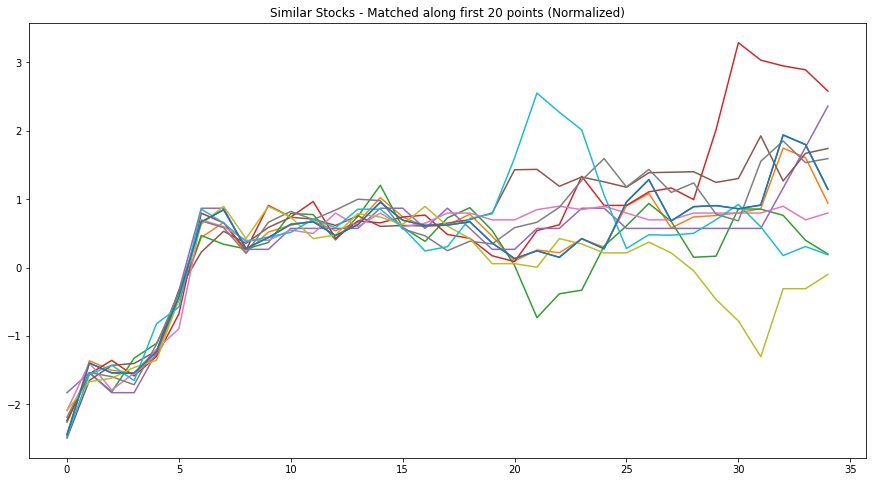

In [219]:

plt.figure(figsize=(15,8))
plt.title("Similar Stocks - Matched along first 20 points (Normalized)")
for row in mysql_results:
    df = fetch_period(row[0], row[1], row[2], PREDICTION_SIZE)
    plt.plot(df[['Close']].values)

plt.plot(np.reshape(fetch_period(stock_filepath, start_date, end_date, PREDICTION_SIZE)['Close'].values.tolist(), (STOCK_WIDTH + PREDICTION_SIZE, 1)))

As we can see, since matching was only performed on the first 20 points, the stocks begin to diverge towards the end of the graphed section. Days 20-35 are our "prediction area".

We generate an average of stocks in our "prediction area", weighted by distance from the target stock as given by Milvus, and calculate a Mean Absolute Percentage Error (MAPE).

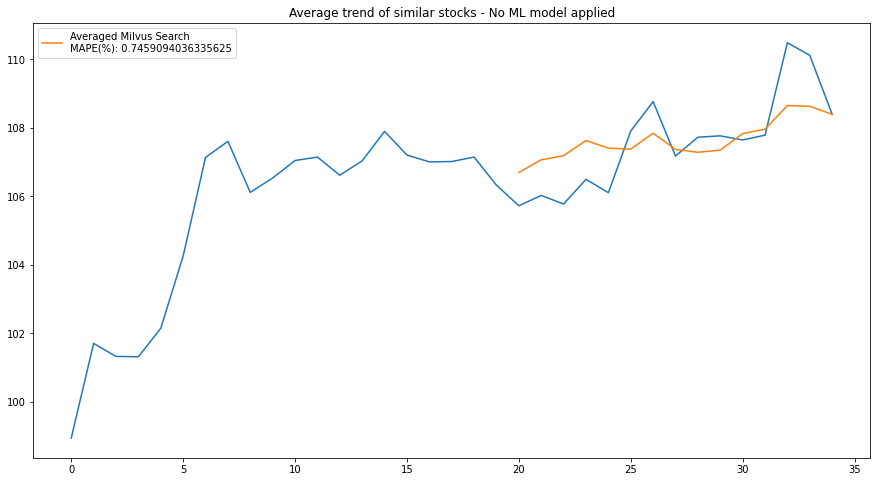

In [220]:
plt.figure(figsize=(15,8))
plt.title("Average trend of similar stocks - No ML model applied")
scaler_original = StandardScaler()
original_points = np.reshape(fetch_period(stock_filepath, start_date, end_date, PREDICTION_SIZE, scaler = scaler_original, fit_scaler=True)['Close'].values.tolist(), (STOCK_WIDTH + PREDICTION_SIZE, 1))
original_points_scaled = scaler_original.inverse_transform(original_points)
predicted_points_search_scaled = scaler_original.inverse_transform(predicted_points_search)



plt.plot(original_points_scaled)
search_mape = mean_absolute_percentage_error(original_points_scaled[-PREDICTION_SIZE:], predicted_points_search_scaled)
plt.plot(range(STOCK_WIDTH, STOCK_WIDTH + PREDICTION_SIZE), predicted_points_search_scaled, label = "Averaged Milvus Search\nMAPE(%): " + str(search_mape * 100))
plt.legend()

As we can see, with a MAPE of 0.7459%, a predictor using just Milvus and no ML model at all performs better than the traditionally used LSTM model!

### Ensemble LSTM 

Now, we'll put together Milvus and LSTMs to create an ensemble learner. We'll train LSTM models on each of the searched stocks, using training points up until the search result period. 

NOTE: It is possible to pre-train models for faster queries, but doing so would massively increase the time required to set up this notebook.

In [201]:
models = []
scalers = []
for row in mysql_results:
    model, scaler = build_model(row[0], row[2], fit_scaler=True)
    models.append(model)
    scalers.append(scaler)

3115/3115 - 50s - loss: 0.0154
3115/3115 - 46s - loss: 0.0206
725/725 - 14s - loss: 0.0816
1805/1805 - 31s - loss: 0.0151
60/60 - 4s - loss: 0.3047
6545/6545 - 95s - loss: 0.0111
3045/3045 - 48s - loss: 0.0191
2865/2865 - 42s - loss: 0.0392
1140/1140 - 19s - loss: 0.0263
2915/2915 - 44s - loss: 0.0271


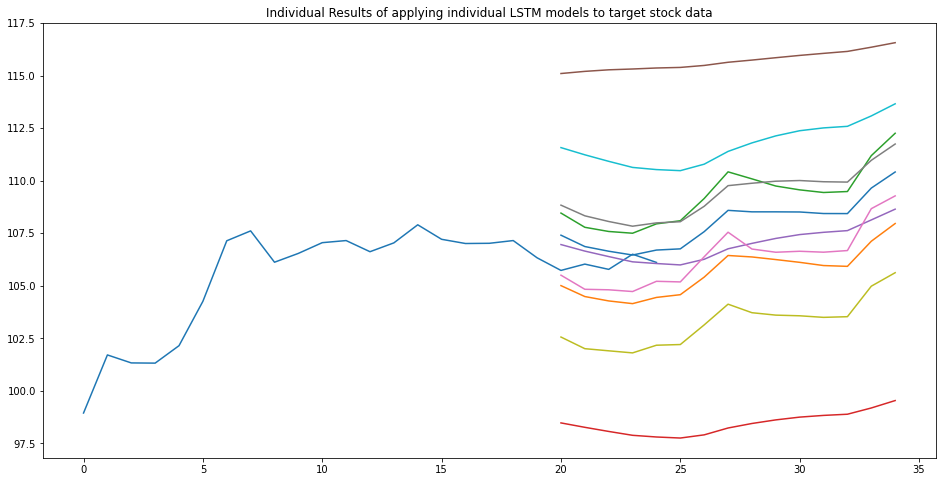

In [202]:

plt.figure(figsize=(16,8))
plt.title("Individual Results of applying individual LSTM models to target stock data")
plt.plot(scalermain.inverse_transform(np.reshape(fetch_period(stock_filepath, start_date, end_date, scaler=scalermain, additional=5)['Close'].values.tolist(), (25, 1))))

predicted_closing_prices_normalized = []
predicted_closing_prices = []
for model, scaler in zip(models, scalers):
    inputs = fetch_period(stock_filepath, starti = -86, end=date(2017,10,6), additional=PREDICTION_SIZE, scaler=scalermain).values
    X_test = []
    for i in range(60,inputs.shape[0]):
        X_test.append(inputs[i-60:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    predicted_closing_price_normalized = model.predict(X_test)
    predicted_closing_prices_normalized.append(closing_price)
    predicted_closing_price = scalermain.inverse_transform(predicted_closing_price_normalized)
    predicted_closing_prices.append(predicted_closing_price)
    plt.plot(range(STOCK_WIDTH, STOCK_WIDTH + PREDICTION_SIZE), predicted_closing_price)

Next, we'll discard outliers based on [Interquartile range](https://en.wikipedia.org/wiki/Interquartile_range) and compute a weighted average to achieve a final result.

In [203]:
avg_predictions = np.average(predicted_closing_prices, axis=1)
q75, q25 = np.percentile(avg_predictions, [75 ,25])
iqr = q75 - q25

distances = [row.distance for row in results[0]]
total_distance = 0
predicted_points = np.zeros((PREDICTION_SIZE, 1))
predicted_points_norm = np.zeros((PREDICTION_SIZE, 1))
for d, data, data_norm in zip(distances, predicted_closing_prices, predicted_closing_prices_normalized):
    data_avg = np.average(data)
    if data_avg <= q75 + 1.5 * iqr and data_avg >= q25 - 1.5 * iqr:
        predicted_points = np.add(predicted_points, data * d)
        predicted_points_norm = np.add(predicted_points_norm, data_norm * d)
        total_distance += d
predicted_points /= total_distance
predicted_points_norm /= total_distance

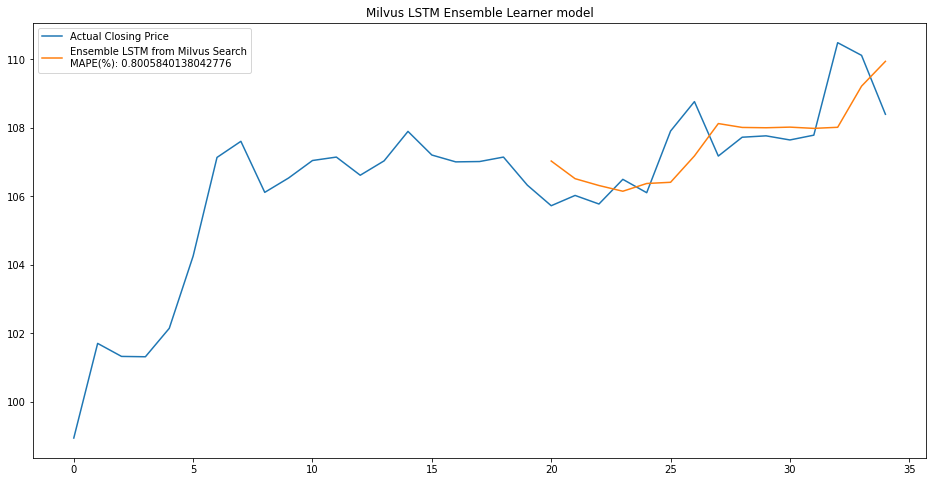

In [222]:
plt.figure(figsize=(16,8))
plt.title("Milvus LSTM Ensemble Learner model")
original_points = np.reshape(fetch_period(stock_filepath, start_date, end_date, scaler=scalermain, additional=PREDICTION_SIZE)['Close'].values.tolist(), (STOCK_WIDTH + PREDICTION_SIZE, 1))
original_points_scaled = scalermain.inverse_transform(original_points)

ensemble_lstm_mape = mean_absolute_percentage_error(original_points_scaled[-PREDICTION_SIZE:], predicted_points)

plt.plot(original_points_scaled, label = "Actual Closing Price")
plt.plot(range(STOCK_WIDTH, STOCK_WIDTH + PREDICTION_SIZE), predicted_points, label = "Ensemble LSTM from Milvus Search\nMAPE(%): " + str(ensemble_lstm_mape * 100))
plt.legend()

With a MAPE of 0.8006%, a predictor combining Milvus and LSTM models in an ensemble format also performs better than a LSTM model.

### Summary

Let's take a look at all three prediction methods plotted on the same graph.

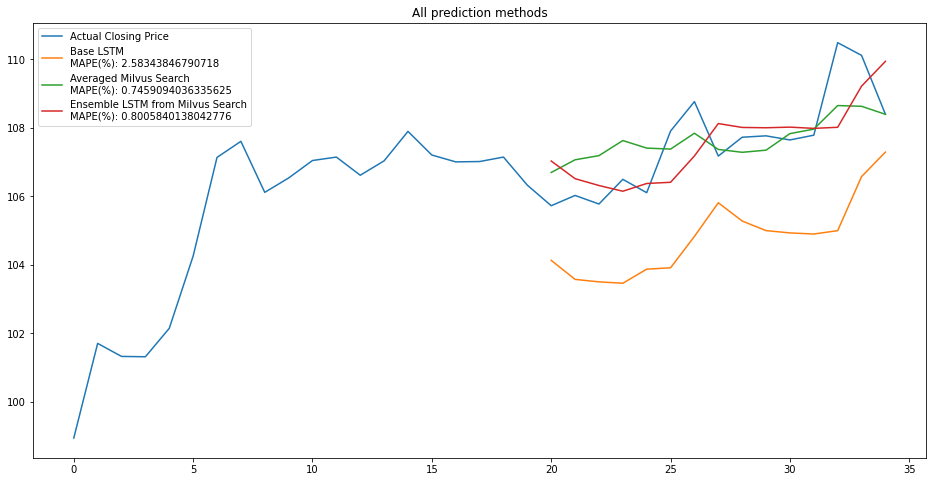

In [212]:
plt.figure(figsize=(16,8))
plt.title("All prediction methods")
plt.plot(original_points_scaled, label = "Actual Closing Price")

lstm_mape = mean_absolute_percentage_error(original_points_scaled[-PREDICTION_SIZE:], closing_price_scaled)
plt.plot(range(STOCK_WIDTH, STOCK_WIDTH + PREDICTION_SIZE), closing_price_scaled, label = "Base LSTM\nMAPE(%): " + str(lstm_mape * 100))
search_mape = mean_absolute_percentage_error(original_points_scaled[-PREDICTION_SIZE:], predicted_points_search_scaled)
plt.plot(range(STOCK_WIDTH, STOCK_WIDTH + PREDICTION_SIZE), predicted_points_search_scaled, label = "Averaged Milvus Search\nMAPE(%): " + str(search_mape * 100))
ensemble_lstm_mape = mean_absolute_percentage_error(original_points_scaled[-PREDICTION_SIZE:], predicted_points)
plt.plot(range(STOCK_WIDTH, STOCK_WIDTH + PREDICTION_SIZE), predicted_points, label = "Ensemble LSTM from Milvus Search\nMAPE(%): " + str(ensemble_lstm_mape * 100))
plt.legend()

### Summary

With MAPEs of 0.7459% and 0.8006%, both Milvus prediction methods significantly outperform a traditional LSTM, which has a MAPE of 2.583%. Both Milvus methods provide a similar MAPE, but surprisingly, the Averaged Milvus Search with no ML model applied narrowly beats the more complex Ensemble LSTM from Milvus Search, with a MAPE difference of 0.597%. 